In [94]:
%matplotlib inline

import os
import struct

import numpy as np
from matplotlib import pyplot as pl
from time import time

import lal
import lalpulsar

In [172]:
# read in reduced basis (txt file)
#rb = np.loadtxt('Basis_real.txt')

# get number of bases
#Nb = rb.shape[0]
#lenb = rb.shape[1]

rundir = '/home/matthew/testing/redordbar'

# get time stamps
ts = np.loadtxt(os.path.join(rundir, 'quad_rule.txt'))
t = ts[:,0]

lenb = len(t)

# get number of basis
Nb = np.loadtxt(os.path.join(rundir, 'ApproxErrors.txt')).shape[0]

# read in binary version of data
bf = open(os.path.join(rundir,'Basis.bin'), 'rb')
fc = bf.read()
bf.close()

rb = np.zeros((Nb,lenb))
for i in range(Nb):
    tmpvals = struct.unpack('d'*lenb*2, fc[(i*8*lenb*2):(i+1)*8*lenb*2])
    rb[i] = tmpvals[::2] # just get real part

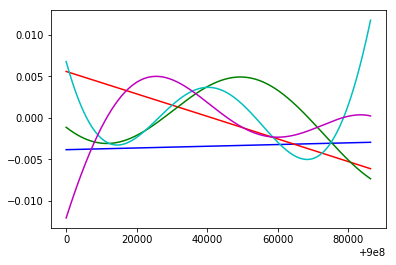

In [173]:
pl.plot(t, rb[0,:], 'b')
pl.plot(t, rb[1,:], 'r')
pl.plot(t, rb[2,:], 'g')
pl.plot(t, rb[3,:], 'c')
pl.plot(t, rb[4,:], 'm')

In [174]:
bpath = '/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/share/lalpulsar'
eephem = os.path.join(bpath, 'earth00-19-DE405.dat.gz')
sephem = os.path.join(bpath, 'sun00-19-DE405.dat.gz')
tephem = os.path.join(bpath, 'te405_2000-2019.dat.gz')

In [175]:
# import ephemeris files
edat = lalpulsar.InitBarycenter(eephem, sephem)
tdat = lalpulsar.InitTimeCorrections(tephem)

In [182]:
# get detector site info
det = lalpulsar.GetSiteInfo('H1')

# create BarycenterInput structure
baryinput = lalpulsar.BarycenterInput()

# setup input structure
baryinput.site = det
baryinput.site.location[0] = baryinput.site.location[0]/lal.C_SI # convert 3d position from metres to light seconds
baryinput.site.location[1] = baryinput.site.location[1]/lal.C_SI
baryinput.site.location[2] = baryinput.site.location[2]/lal.C_SI

baryinput.dInv = 0.0

# test across the sky
nsky = 2000
maxres = [] # maximum residuals

deltaTs = np.zeros(lenb)

# set EarthState structure
earth = lalpulsar.EarthState()

# set EmissionTime structure
emit = lalpulsar.EmissionTime()

validationpoints = os.path.join(rundir, 'validation/validation_points.txt')
skypoints = np.loadtxt(validationpoints)
ras = skypoints[:,0]
decs = skypoints[:,1]
nsky = len(ras)

# set source sky positions
#ras = 2.*np.pi*np.random.rand(nsky)
#decs = -(np.pi/2.) + np.arccos(2.*np.random.rand(nsky) - 1.)

deltaTsArray = []
# get deltaTs calculated using over all times using LALBarycenter routines
t0 = time()
for i in range(nsky):
    # set source sky position
    baryinput.alpha = ras[i]
    baryinput.delta = decs[i]

    # set GPS time
    for j, tv in enumerate(t):
        tgps = lal.LIGOTimeGPS(int(np.floor(tv)), int(1e9*(tv-np.floor(tv))))

        # perform Earth barycentring
        lalpulsar.BarycenterEarthNew(earth, tgps, edat, tdat, lalpulsar.TIMECORRECTION_TCB)

        # perform barycentring
        lalpulsar.Barycenter(emit, baryinput, earth)

        deltaTs[j] = emit.deltaT
    
    deltaTsArray.append(np.copy(deltaTs))
t1 = time()

timefull = t1-t0

# get indexes for interpolation
interpidx = np.arange(0, lenb, int(lenb/Nb))
interptimes = t[interpidx]

# get values of reduced basis at given points
rbmat = rb[:,interpidx].T
dtvals = np.zeros(Nb)

deltaTsArrayNew = []
# get deltats calculated using the reduced basis
t0 = time()
for i in range(nsky):
    # set source sky position
    baryinput.alpha = ras[i]
    baryinput.delta = decs[i]
    
    # get values of generate deltaT at given points
    for j, tv in enumerate(interptimes):
        tgps = lal.LIGOTimeGPS(int(np.floor(tv)), int(1e9*(tv-np.floor(tv))))

        # perform Earth barycentring
        lalpulsar.BarycenterEarthNew(earth, tgps, edat, tdat, lalpulsar.TIMECORRECTION_TCB)

        # perform barycentring
        lalpulsar.Barycenter(emit, baryinput, earth)

        dtvals[j] = emit.deltaT

    # invert rbmat and solve for coefficients
    #C = np.linalg.inv(rbmat)
    #A = np.dot(dtvals, C)
    A = np.linalg.solve(rbmat, dtvals) # faster and more numerically stable than the above

    # create new version of deltaTs
    deltaTsArrayNew.append(np.dot(A, rb))
t1 = time()

timereduced = t1-t0
    
for dt1, dt2 in zip(deltaTsArray, deltaTsArrayNew):
    residual = dt1 - dt2
    maxres.append(np.max(np.abs(residual)))
    
print("Time to run full Barycenter calculation: %e s" % (timefull/nsky))
print("Time to run reduced Barycenter calculation: %e s" % (timereduced/nsky))
print("Time ratio: %.3f" % (timefull/timereduced))

Time to run full Barycenter calculation: 6.241970e-03 s
Time to run reduced Barycenter calculation: 4.758782e-05 s
Time ratio: 131.167


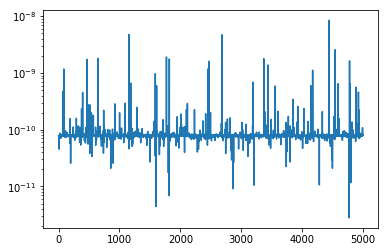

In [183]:
pl.semilogy(maxres)

In [184]:
# compare also with empirical interpolant
indices = []
ts_nodes = []

e = np.array(rb)
V = np.zeros((len(e), len(e)))

indices.append(int(np.argmax(np.abs(e[0]))))
ts_nodes.append(t[indices[0]])

#build empirical interpolant
for i in range(1, len(e)):
    for j in range(len(indices)):
        for k in range(len(indices)):
            V[j][k] = e[j][indices[k]]

    B = np.linalg.solve(V[0:len(indices), 0:len(indices)], e[0:len(indices)])
    interpolant = np.inner(e[i,indices].T, B.T)
    res = interpolant - e[i]

    index = int(np.argmax(np.abs(res)))
    indices.append(index)
    ts_nodes.append(t[index])
        
# make B matrix with all the indices
for j in range(len(indices)):
    for k in range(len(indices)):
        V[j][k] = e[j][indices[k]]

B = np.linalg.solve(V[0:len(indices), 0:len(indices)], e[0:len(indices)])
B = B.T

deltaTsArrayNew2 = []
# get deltats calculated using the reduced basis
t0 = time()
for i in range(nsky):
    # set source sky position
    baryinput.alpha = ras[i]
    baryinput.delta = decs[i]
    
    # get values of generate deltaT at given points
    for j, tv in enumerate(ts_nodes):
        tgps = lal.LIGOTimeGPS(int(np.floor(tv)), int(1e9*(tv-np.floor(tv))))

        # perform Earth barycentring
        lalpulsar.BarycenterEarthNew(earth, tgps, edat, tdat, lalpulsar.TIMECORRECTION_TCB)

        # perform barycentring
        lalpulsar.Barycenter(emit, baryinput, earth)

        dtvals[j] = emit.deltaT

    # create new version of deltaTs using empirical interpolant matrix
    deltaTsArrayNew2.append(np.inner(B, dtvals))
t1 = time()

timereduced2 = t1-t0

print("Time to run (second) reduced Barycenter calculation: %e s" % (timereduced2/nsky))

Time to run (second) reduced Barycenter calculation: 3.060999e-05 s


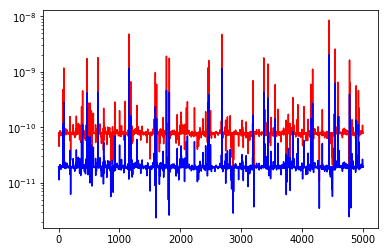

In [185]:
maxres2 = []
for dt1, dt2 in zip(deltaTsArray, deltaTsArrayNew2):
    residual = dt1 - dt2
    maxres2.append(np.max(np.abs(residual)))

pl.semilogy(maxres, 'r')
pl.semilogy(maxres2, 'b')

In [188]:
np.sqrt(np.sum(maxres2[2]**2))

1.8985701899509877e-11

In [189]:
np.linalg.inv(V).T

array([[   2.51099094,  -31.88166617, -127.51167682, -121.13833104,
         -15.07368744],
       [  19.59504072,  -25.47630153,   -4.86421345,   86.3784239 ,
         -97.8970095 ],
       [ -15.92098592,  -28.65924898,  127.17543593,  -30.93035771,
         -51.70484444],
       [   2.3058183 ,   45.38709138,   43.89630833,   -6.14942637,
         -85.43750178],
       [ -71.8660389 ,   26.53507627,   50.95018305,   78.05534413,
         -83.67454377]])